In [1]:
!pip install resampy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install np_utils

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, f1_score, log_loss


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score


import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [6]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [7]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [8]:
len(df)

3480

In [9]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [10]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [01:29, 39.08it/s]


In [11]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [12]:
len(sorted_df)

3471

In [13]:
df_class1 = sorted_df[sorted_df['class'] == 'IRoar']
df_class2 = sorted_df[sorted_df['class'] == 'Roar']
df_class3 = sorted_df[sorted_df['class'] == 'Grunt']

# Randomly select 900 samples from each class
sample_size = 900
df_class1_balanced = df_class1.sample(n=sample_size, random_state=42)
df_class2_balanced = df_class2.sample(n=sample_size, random_state=42)
df_class3_balanced = df_class3.sample(n=sample_size, random_state=42)

# Combine the balanced DataFrames into a single DataFrame
df_balanced = pd.concat([df_class1_balanced, df_class2_balanced, df_class3_balanced])

# Shuffle the combined DataFrame to mix the samples from all three classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [15]:
appended = []
for i in range(1,4):
    appended.append(df_balanced[df_balanced.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Roar,IRoar,Grunt
0,fold1,305,301,298
1,fold2,297,299,304
2,fold3,298,300,298


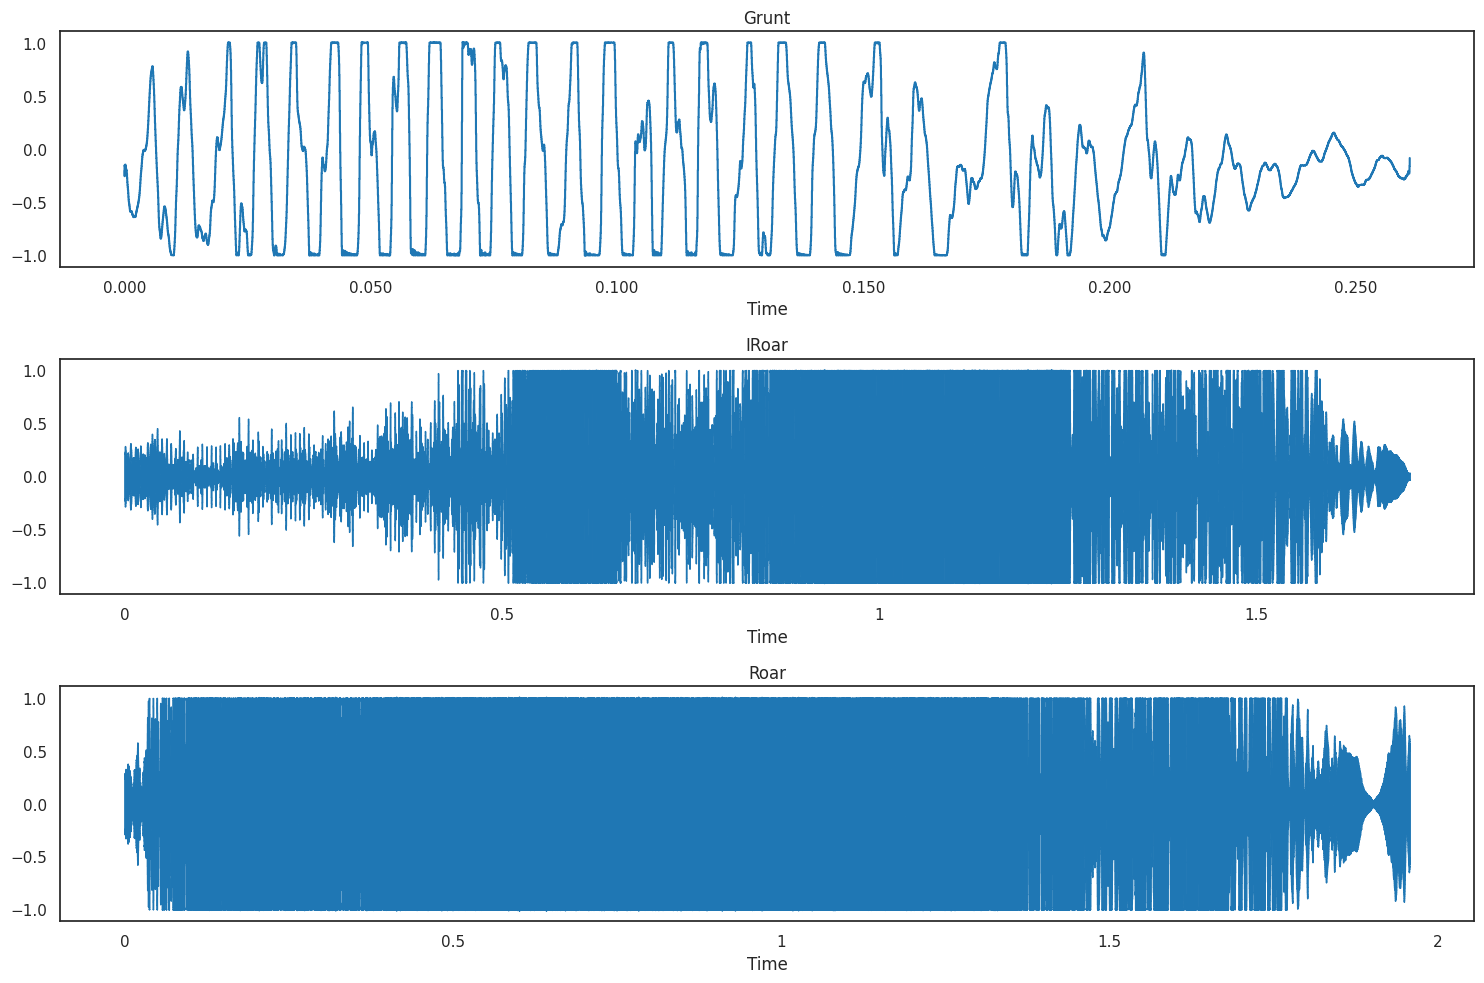

In [16]:
# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

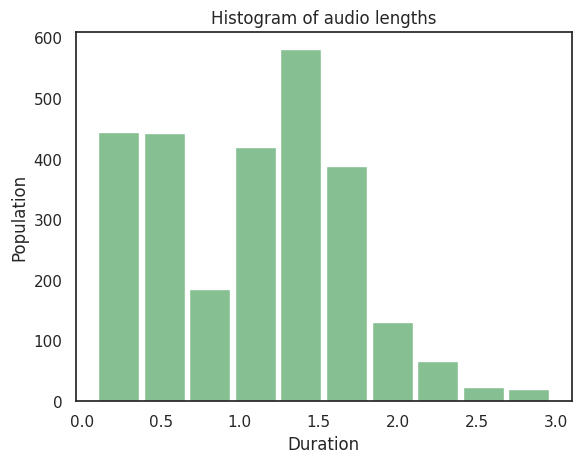

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 140
Lower than 2 but greater than 1 seconds: 1447
Lower than 1 seconds: 1113


In [17]:
plt.hist(df_balanced['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = df_balanced['duration'][(df_balanced['duration'] > 3)].count()
gt_2sec = df_balanced['duration'][(df_balanced['duration'] > 2) & (df_balanced['duration'] < 3)].count()
lt_2sec = df_balanced['duration'][(df_balanced['duration'] > 1) & (df_balanced['duration'] < 2)].count()
lt_1sec = df_balanced['duration'][df_balanced['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [18]:
df_balanced.head()

,fs_id,slice_file_name,classID,fold,class,filepath,duration
0,roar_276,roar_276.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_2...,2.337959
1,roar_76,roar_76.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_7...,1.623946
2,roar_314,roar_314.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_3...,1.236054
3,iroar_628,iroar_628.wav,1,2,IRoar,/content/drive/MyDrive/ThesisData/File2/iroar_...,1.789161
4,roar_784,roar_784.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_7...,1.567619


In [19]:
df_balanced.groupby(['class'])['duration'].max()

class
Grunt    1.696372
IRoar    2.971837
Roar     2.877506
Name: duration, dtype: float64

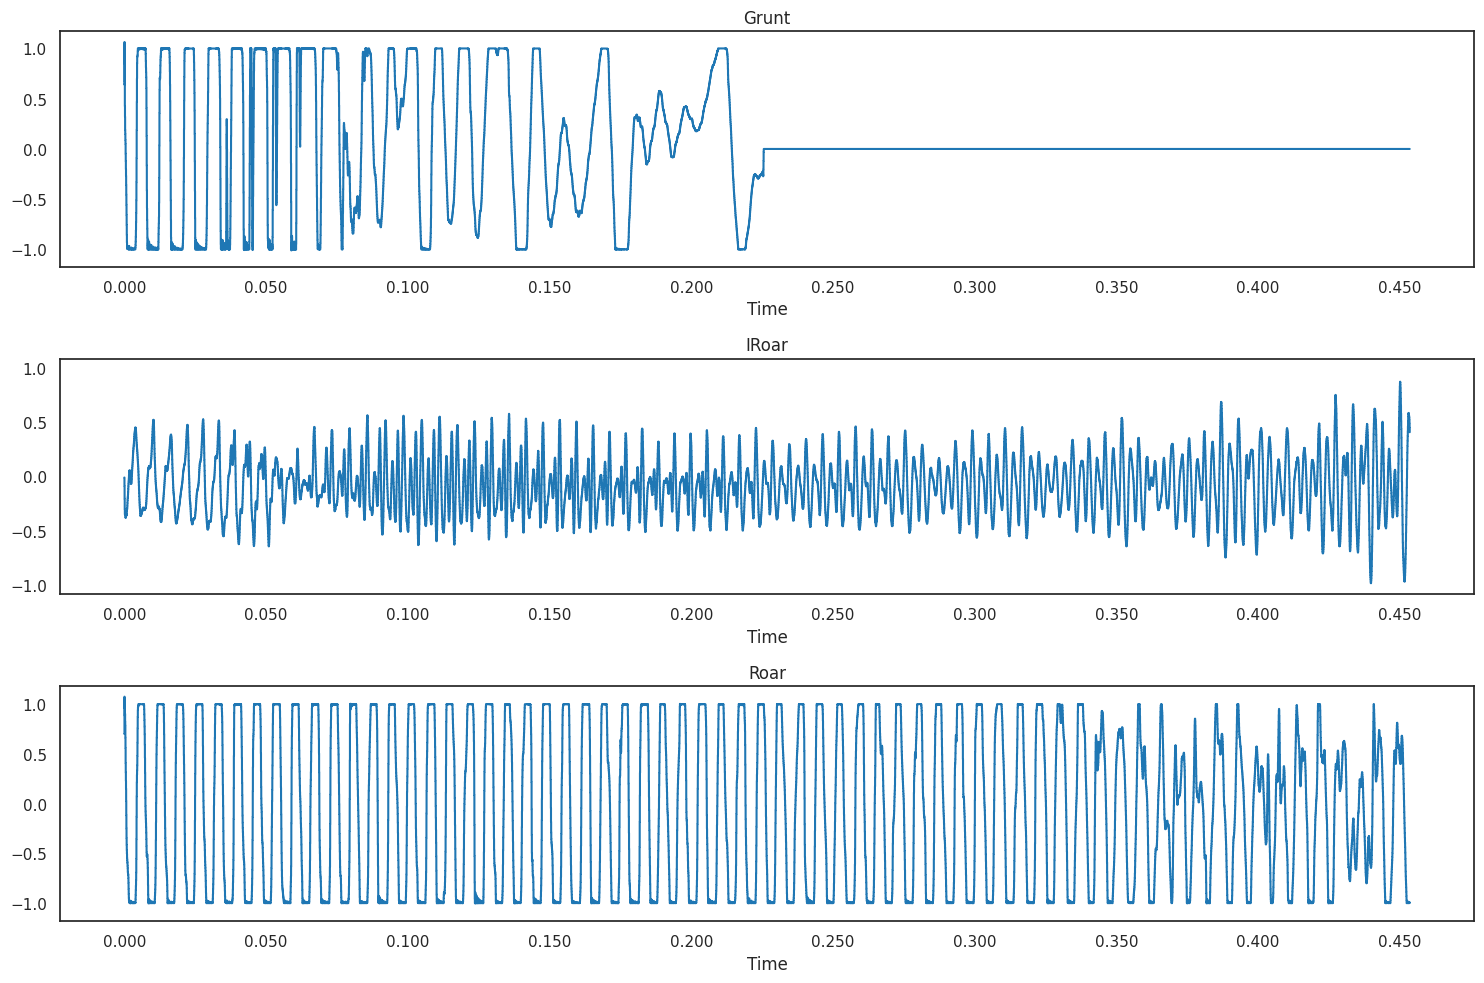

In [20]:
start = 0
end = 0
max_audio_duration = 3

# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()


# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    y_trimmed, _ = librosa.effects.trim(audio_file)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sample_rate)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y_trimmed)), mode='constant')

    if labels[index] == "IRoar":
      start = 0
      end= 10000
    elif labels[index] == "Roar":
      start = 0
      end= 10000
    elif labels[index] == "Grunt":
      start = 0
      end= 10000
    librosa.display.waveshow(y=y_trimmed[start:end], sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

In [21]:
# Feature extraction using librosa

data = []
labels = []
max_audio_duration = 3

start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(df_balanced))):
    fold_no=str(df_balanced.iloc[i]["fold"])
    file=df_balanced.iloc[i]["slice_file_name"]
    label=df_balanced.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sr)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y)), mode='constant')

    if df_balanced.iloc[i]["class"] == "IRoar":
      start = 0
      end= 3000
    elif df_balanced.iloc[i]["class"] == "Roar":
      start = 0
      end= 3000
    elif df_balanced.iloc[i]["class"] == "Grunt":
      start = 0
      end= 3000
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)
    mfccs_std = np.std(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)

    # Extract RMSE (temporal patterns)
    rmse_mean = np.mean(librosa.feature.rms(y=y_trimmed[start:end]))
    rmse_std = np.std(librosa.feature.rms(y=y_trimmed[start:end]))

    features = np.concatenate((mfccs_mean, mfccs_std, [rmse_mean, rmse_std]))

    data.append(features)
    labels.append(label)

100%|██████████| 2700/2700 [02:35<00:00, 17.39it/s]


In [22]:
data=np.array(data)
labels=np.array(labels)

In [23]:
data.shape, labels.shape

((2700, 28), (2700,))

In [24]:
# Shuffle the data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [25]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(labels)

In [26]:
from sklearn.utils.class_weight import compute_class_weight

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Define the number of folds for cross-validation
n_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store evaluation metrics
accuracy_A_vs_B_C_scores = []
accuracy_B_vs_C_scores = []
confusion_matrices_A_vs_B_C = []
confusion_matrices_B_vs_C = []
loss_A_vs_B_C_scores = []
loss_B_vs_C_scores = []

# Initialize Stratified K-Fold Cross-Validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [30]:
# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(data, y_encoded):
    # Split the data into train and test sets for this fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Calculate class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Initialize and train the SVM model with class weights
    C_value = 1.0  # You can experiment with different C values

    # Data Preprocessing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 1: Train the first SVM classifier for Class A vs. Class (B+C)
    svm_A_vs_B_C = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)

    # Create a new target variable for binary classification
    # 1 for Class A, 0 for Class (B+C)
    y_binary_train = [1 if label == 2 else 0 for label in y_train]
    y_binary_test = [1 if label == 2 else 0 for label in y_test]

    # Train the first SVM classifier
    svm_A_vs_B_C.fit(X_train, y_binary_train)

    # Make predictions for Class A vs. Class (B+C)
    predictions_A_vs_B_C = svm_A_vs_B_C.predict(X_test)

    # Calculate confusion matrix for Class A vs. Class (B+C)
    cm_A_vs_B_C = confusion_matrix(y_binary_test, predictions_A_vs_B_C)
    confusion_matrices_A_vs_B_C.append(cm_A_vs_B_C)

    # Calculate accuracy for Class A vs. Class (B+C)
    accuracy_A_vs_B_C = accuracy_score(y_binary_test, predictions_A_vs_B_C)
    accuracy_A_vs_B_C_scores.append(accuracy_A_vs_B_C)

    # Calculate log loss for Class A vs. Class (B+C)
    prob_A_vs_B_C = svm_A_vs_B_C.predict_proba(X_test)  # Predicted probabilities
    loss_A_vs_B_C = log_loss(y_binary_test, prob_A_vs_B_C)
    loss_A_vs_B_C_scores.append(loss_A_vs_B_C)

    # Step 2: Train the second SVM classifier for Class B vs. Class C
    X_train_B_C = X_train[(y_train == 1) | (y_train == 0)]
    y_train_B_C = y_train[(y_train == 1) | (y_train == 0)]

    X_test_B_C = X_test[(y_test == 1) | (y_test == 0)]
    y_test_B_C = y_test[(y_test == 1) | (y_test == 0)]

    # Train the second SVM classifier
    svm_B_vs_C = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)

    svm_B_vs_C.fit(X_train_B_C, y_train_B_C)

    # Make predictions for Class B vs. Class C
    predictions_B_vs_C = svm_B_vs_C.predict(X_test_B_C)

    # Calculate confusion matrix for Class B vs. Class C
    cm_B_vs_C = confusion_matrix(y_test_B_C, predictions_B_vs_C)
    confusion_matrices_B_vs_C.append(cm_B_vs_C)

    # Calculate log loss for Class B vs. Class C
    prob_B_vs_C = svm_B_vs_C.predict_proba(X_test_B_C)  # Predicted probabilities
    loss_B_vs_C = log_loss(y_test_B_C, prob_B_vs_C)
    loss_B_vs_C_scores.append(loss_B_vs_C)

    # Calculate accuracy for Class B vs. Class C
    accuracy_B_vs_C = accuracy_score(y_test_B_C, predictions_B_vs_C)
    accuracy_B_vs_C_scores.append(accuracy_B_vs_C)

# Calculate the mean accuracy over all folds for both classifiers
mean_accuracy_A_vs_B_C = np.mean(accuracy_A_vs_B_C_scores)

print("Accuracy scores for each fold for Grunt vs Not Grunt:", accuracy_A_vs_B_C_scores)
print("Mean accuracy for Grunt vs Not Grunt:", mean_accuracy_A_vs_B_C)

# Calculate the mean accuracy over all folds for the second classifier
mean_accuracy_B_vs_C = np.mean(accuracy_B_vs_C_scores)

print("Accuracy scores for each fold for Roar vs IRoar:", accuracy_B_vs_C_scores)
print("Mean accuracy for Roar vs IRoar:", mean_accuracy_B_vs_C)

mean_loss_A_vs_B_C = np.mean(loss_A_vs_B_C_scores)
mean_loss_B_vs_C = np.mean(loss_B_vs_C_scores)
print("Log Loss for each fold for Grunt vs Not Grunt:", loss_A_vs_B_C_scores)
print("Mean Log Loss for Grunt vs Not Grunt:", mean_loss_A_vs_B_C)

print("Log Loss for each fold for Roar vs IRoar:", loss_B_vs_C_scores)
print("Mean Log Loss for Roar vs IRoar:", mean_loss_B_vs_C)

# Print confusion matrices for both classifiers
for i, (cm_A_vs_B_C, cm_B_vs_C) in enumerate(zip(confusion_matrices_A_vs_B_C, confusion_matrices_B_vs_C)):
    print(f"Fold {i + 1} - Confusion Matrix for Grunt vs Not Grunt:\n", cm_A_vs_B_C)
    print(f"Fold {i + 1} - Confusion Matrix for Roar vs IRoar:\n", cm_B_vs_C)

Accuracy scores for each fold for Grunt vs Not Grunt: [0.8629629629629629, 0.8666666666666667, 0.8648148148148148, 0.8759259259259259, 0.8629629629629629]
Mean accuracy for Grunt vs Not Grunt: 0.8666666666666666
Accuracy scores for each fold for Roar vs IRoar: [0.85, 0.8138888888888889, 0.8388888888888889, 0.8277777777777777, 0.8555555555555555]
Mean accuracy for Roar vs IRoar: 0.8372222222222222
Log Loss for each fold for Grunt vs Not Grunt: [0.27820744739137954, 0.2869668282012366, 0.29104169532601326, 0.2577642639900495, 0.2861586656616561]
Mean Log Loss for Grunt vs Not Grunt: 0.28002778011406704
Log Loss for each fold for Roar vs IRoar: [0.36619451381631507, 0.3713093264679559, 0.36013906378291244, 0.41052342201460185, 0.34108278281175086]
Mean Log Loss for Roar vs IRoar: 0.36984982177870723
Fold 1 - Confusion Matrix for Grunt vs Not Grunt:
 [[298  62]
 [ 12 168]]
Fold 1 - Confusion Matrix for Roar vs IRoar:
 [[155  25]
 [ 29 151]]
Fold 2 - Confusion Matrix for Grunt vs Not Grunt:

In [31]:
# Plot confusion matrices
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

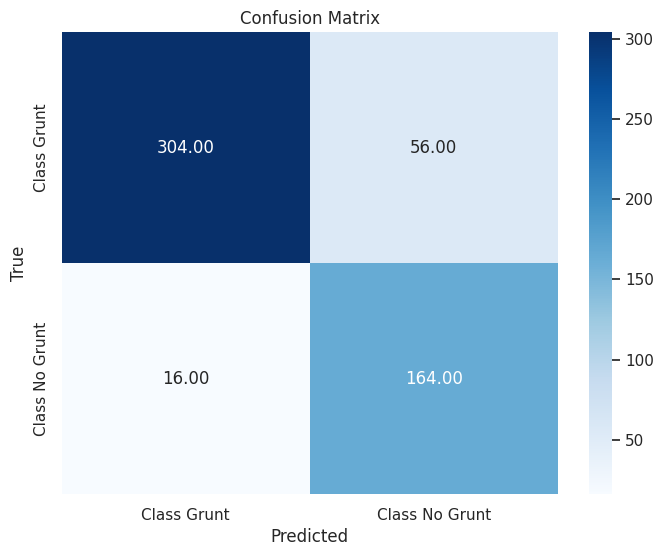

In [32]:
# Plot confusion matrix for Class A vs. Class (B+C)
plot_confusion_matrix(np.mean(confusion_matrices_A_vs_B_C, axis=0), labels=['Class Grunt', 'Class No Grunt'])

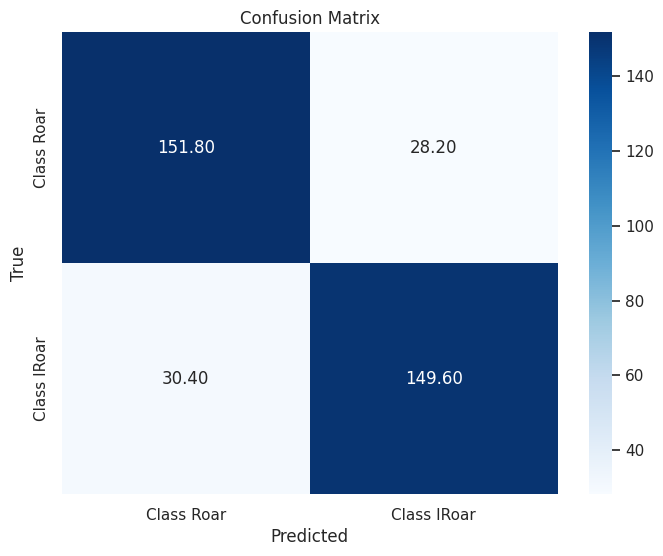

In [33]:
# Plot confusion matrix for Class B vs. Class C
plot_confusion_matrix(np.mean(confusion_matrices_B_vs_C, axis=0), labels=['Class Roar', 'Class IRoar'])